### Linear models.

#### Linear regression

Первый метод, который будет представлен, это метод линейной регресии. Один из самый простых и неточных, однако, при должной обработке изначальных данных, может быть полезен. Метод заключается в предполодении, что зависимая, объясняемая переменная $y$ находится в линейной связи с фичами, плюс еще некоторая ошибка $\varepsilon$, матожидание которой равно нулю. 

$$
y_i = \beta_{0} + \beta_{1} x_{i1} + \cdots + \beta_{p} x_{ip} + \varepsilon_i
 = \mathbf{x}^\mathsf{T}_i\boldsymbol\beta + \varepsilon_i,
 \qquad i = 1, \ldots, n
$$ 
Или, как это записывается в матричной форме
$$
\mathbf{y} = X\boldsymbol\beta + \boldsymbol\varepsilon,
$$

Однако на исходные даннеы требуется сделать большое число предположения и ограничений, чтобы модель можно было считать корректной.


#### Ridge regression
Модель минимизирует следующее:
$$
||y - Xw||^2_2 + \alpha * ||w||^2_2
$$

#### Huber regression
Модель минимизирует квадратичную ошибку в области $|(y - X'w) / \sigma| < \varepsilon$, а вне этой области - линейную ошибку. Таким образом модель более толерантна к выбросам, так что, в некоотором смысле, часто предпочтительнее, чем просто минимизация любой из MAE или MSE.


Приведем пример использования регрессии для предсказания цен на недвижимость, используя данные стандартного датасета california_pricing.

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear
from sklearn.datasets import california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [2]:
data = california_housing.fetch_california_housing()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

В первую очередь требуется посмотреть на распределение фич, для этого воспользуемся функцией jointplot.

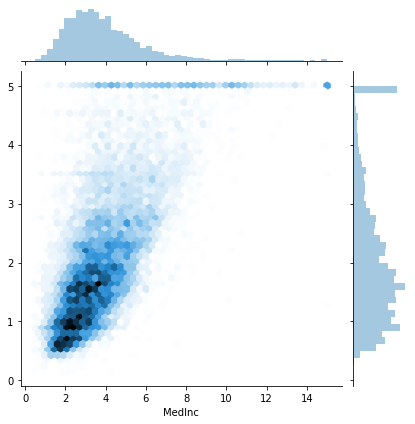

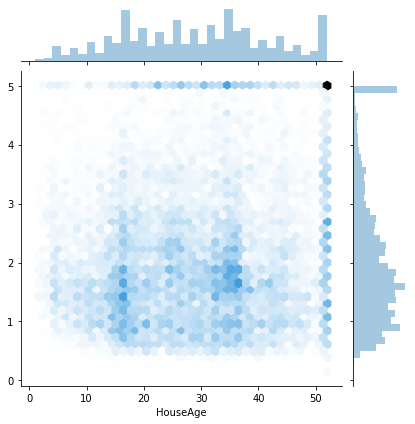

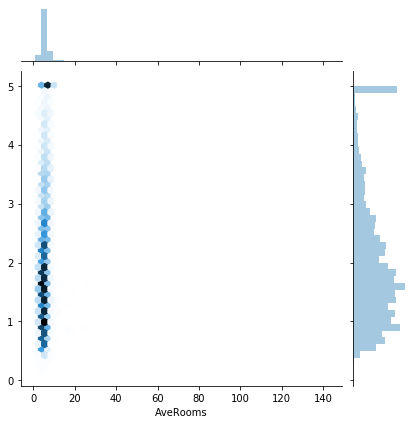

In [3]:
for column in X_train.columns[:3]:
    sns.jointplot(X_train[column], y_train, kind = 'hex')
    plt.show()

Теперь можно посмотреть на общую сводную статистику по датасету.

In [4]:
X_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.863674,28.696253,5.449346,1.101852,1418.907364,3.054763,35.646553,-119.581988
std,1.901407,12.573916,2.657877,0.524510,1103.624949,10.824345,2.142808,2.007080
min,0.499900,1.000000,0.888889,0.333333,5.000000,0.692308,32.540000,-124.350000
25%,2.562500,18.000000,4.438917,1.006715,787.000000,2.427145,33.940000,-121.810000
50%,3.531300,29.000000,5.232342,1.048780,1160.000000,2.811623,34.260000,-118.500000
75%,4.732675,37.000000,6.051033,1.100046,1720.000000,3.271666,37.720000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,1243.333333,41.950000,-114.310000


Для начала посмотрим, насколько хорошо работает регрессия из коробки, на сырых данных

In [5]:
def observe(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    def print_metric(y_true, y_pred):
        print(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 'MAPE')
        print(mean_absolute_error(y_true, y_pred), 'MAE')
        print(mean_squared_error(y_true, y_pred), 'MSE')
        
        
    regressor = model
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print_metric(y_test, y_pred)
    sns.scatterplot(y_test, y_pred)
    plt.xlabel('true')
    plt.ylabel('prediction')

31.655160452535995 MAPE
0.5390874296025571 MAE
0.5396014510325683 MSE


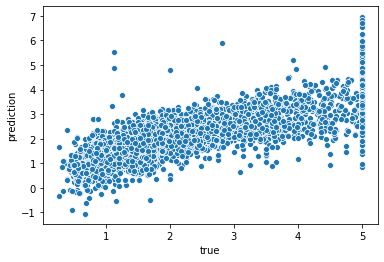

In [6]:
observe(linear.LinearRegression())

31.656246966032942 MAPE
0.5391013295952537 MAE
0.5396211056552381 MSE


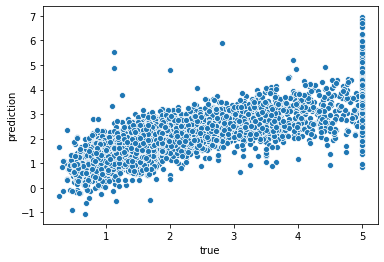

In [7]:
observe(linear.Ridge())

Для большинства сколь-нибудь сложных моделей часто используется кросс-валидация, то есть разбиение изначального датасета на части, обучение на каждой конкретной части и потом тестирование на оставшихся частях. Это используется для того, чтобы, по возможности, уменишить переобучение. Сравним, как работает Ridge с и без кросс-валидации. В данном случае улучшение не очень заметно, но в иных примерах оказывается необходимо.

31.665855855048598 MAPE
0.5392248393844331 MAE
0.5397981111331911 MSE


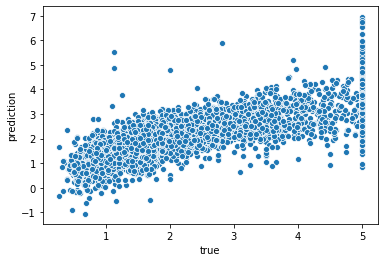

In [8]:
observe(linear.RidgeCV())

У большинства моделей присутсвуют различные гиперпараметры, от правильного выбора которых также зависит качество модели.

In [9]:
parameters = {'alpha':np.linspace(0.1, 10, 100), 'fit_intercept':[True, False], 'normalize': [True, False]}
clf = GridSearchCV(linear.Ridge(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)

{'alpha': 10.0, 'fit_intercept': True, 'normalize': False}


31.662372515222614 MAPE
0.5391799940067444 MAE
0.5397331919080618 MSE


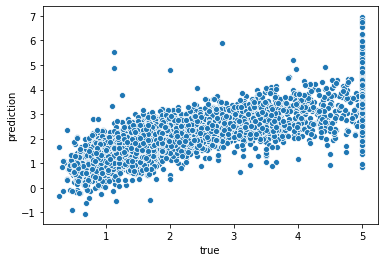

In [10]:
observe(linear.Ridge(alpha=6.7, fit_intercept = True, normalize= False))

Тут вышло, что параметры по умолчанию были близки к оптимальным. РАссмотрим пример, где это дает больший прирост.

32.70208998125479 MAPE
0.5810337521301151 MAE
1.0075227508096025 MSE


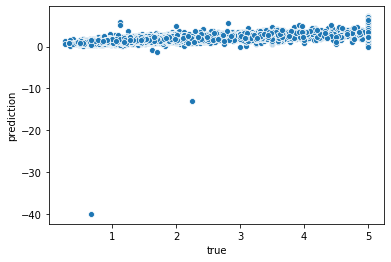

In [11]:
observe(linear.HuberRegressor())

In [14]:
parameters = {'epsilon':np.linspace(8, 10, 10), 'alpha': np.linspace(0.4, 0.5, 10)}
clf = GridSearchCV(linear.HuberRegressor(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)

{'alpha': 0.4666666666666667, 'epsilon': 8.222222222222221}


36.62062478332634 MAPE
0.6075755889492431 MAE
0.6567142587678497 MSE


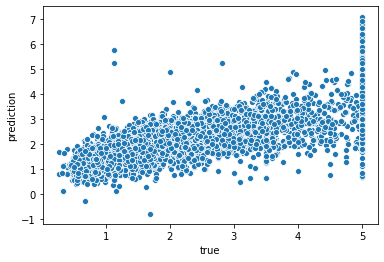

In [16]:
observe(linear.HuberRegressor(alpha = 0.4666, epsilon=8.2222))

Немного увеличился MAPE и MAE, но сильно лучше стал MSE.